In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
python3 = True

# Environment variables setting

In [2]:
# Setting environment variables
import sys, os
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")
if python3: os.environ['PYSPARK_PYTHON'] = "vsb/CI_conda_env_py3/bin/python"

# Import of useful packages and modules

In [3]:
import pandas as pd
pd.set_option('max_colwidth', None)
import itertools
import numpy as np
from numpy import nanargmax
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import sklearn
import time
from pandas.core.common import flatten
import pickle
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
# Importing spark libs
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix

# Spark configuration 

In [4]:
# Stopping the current session if exists
try:
    session.stop()
except:
    pass

In [5]:
# Setting up the spark configurator  
conf = SparkConf()
conf.set('spark.serializer', "org.apache.spark.serializer.KryoSerializer")       
conf.set('spark.executor.memory', '16g')
conf.set('spark.driver.memory', '16g')
conf.set('spark.executor.cores', '3')
conf.set('spark.driver.cores', '3')
conf.set('spark.dynamicAllocation.enabled', 'true')
conf.set('spark.executor.instances', '4')
conf.set('spark.dynamicAllocation.minExecutors', '4')
conf.set('spark.dynamicAllocation.maxExecutors', '12')
conf.set('spark.executor.memoryOverhead', '8096')
conf.set('spark.driver.memoryOverhead', '8096')
conf.set('spark.driver.maxResultSize', '20g')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.setAppName('DA_Modeling_Micro')
if python3: conf.set("spark.yarn.dist.archives", "/home/anxadvuser/anx_adv_achurn/env_conda_py3.zip#vsb")

# Creating the spark session object
session = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()

In [6]:
session

# Modeling

In [7]:
train_set_features_selected_micro = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_features_selected_micro").cache()
test_set_features_selected_micro = session.read.parquet("/bda/anx_adv_achurn/durand/test_set_features_selected_micro").cache()

In [8]:
train_set_subset_micro = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_micro_balanced_numeric_subset").cache()

In [9]:
train_set_features_selected_micro.count()

10976832

In [10]:
test_set_features_selected_micro.count()

4041295

In [11]:
def dtypes(df_in):
    """
    Generate the data type categories: numerical, categorical, date and unsupported category.
    :param df_in: the input rdd data frame
    :return: data type categories
    """

    # all data types in pyspark (for reference)
    # __all__ = [
    # "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    # "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    # "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType', 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    # qualitative data types in rdd DataFrame dtypes
    cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']
    # date data types in rdd DataFrame dtypes
    date_types = ['DateType', 'TimestampType']
    # unsupported data types in rdd DataFrame dtypes
    unsupported_types = ['ArrayType', 'MapType', 'StructField', 'StructType']

    all_fields = [(f.name, str(f.dataType)) for f in df_in.schema.fields]

    all_df = pd.DataFrame(all_fields, columns=['feature', 'DataType'])

    # initialize the memory for the corresponding fields
    num_fields = []
    cat_fields = []
    date_fields = []
    unsupported_fields = []

    [num_fields.append(item[0]) if item[1] in num_types else
     cat_fields.append(item[0]) if item[1] in cat_types else
     date_fields.append(item[0]) if item[1] in date_types else
     unsupported_fields.append(item[0]) for item in all_fields]

    return all_df, num_fields, cat_fields, date_fields, unsupported_fields


def get_encoded_names(df_in, categorical_cols):
    """
    get the encoded dummy variable names
    :param df_in: the input dataframe
    :param categorical_cols: the name list of the categorical columns
    :return: the name list of the encoded dummy variable for categorical columns
    """

    ind_names = [df_in.groupBy(c).count().sort(F.col("count").desc()).select(c).rdd.flatMap(lambda x: x).collect()
                 for c in categorical_cols]

    encodered_name = [categorical_cols[i] + '_' + j for i in range(len(categorical_cols)) for j in ind_names[i]]

    return encodered_name


def get_assembled_data(df_in, index_col=None, categorical_cols=None, continuous_cols=None, label_col=None, dropLast=False):
    """
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df_in: the dataframe
    :param categorical_cols: the name list of the categorical data
    :param continuous_cols:  the name list of the numerical data
    :param label_col:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: encoded dummy variable names and feature matrix
    """

    # exclude index col and label col
    excluded = list(flatten([index_col, label_col]))

    if continuous_cols:
        continuous_cols = [col for col in continuous_cols if col not in excluded]
    else:
        continuous_cols = []

    if categorical_cols:
        categorical_cols = [col for col in categorical_cols if col not in excluded]
    else:
        categorical_cols = []

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_cols]

    # default setting: dropLast=True
    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                              outputCol="{0}_encoded".format(indexer.getOutputCol()), dropLast=dropLast)
                for indexer in indexers]

    assembler = VectorAssembler(inputCols=continuous_cols + [encoder.getOutputCol() for encoder in encoders],
                                outputCol="assembled_features")
    
    # Standard Scaler: 
    #We use the Standard Scaler to put all the numbers on the same scale, which is standard practice 
    #for machine learning. This takes the observation and subtracts the mean, and then divides that 
    #by the standard deviation.
    
    standardscaler = StandardScaler().setInputCol("assembled_features").setOutputCol("features")
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler] + [standardscaler])

    encodered_col_names = get_encoded_names(df_in, categorical_cols)
    assembled_col_names = continuous_cols + encodered_col_names

    model = pipeline.fit(df_in)
    data = model.transform(df_in)

    if index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', F.col(label_col))
        out_data = data.select(*list(flatten([index_col, 'features', 'label'])))
    elif not index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', F.col(label_col))
        out_data = data.select('features', 'label')
    elif index_col and not label_col:
        # for unsupervised learning
        out_data = data.select(*list(flatten([index_col, 'features'])))
    elif not index_col and not label_col:
        # for unsupervised learning
        out_data = data.select('features')

    return assembled_col_names, out_data


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    if cmap is None:
        cmap = plt.get_cmap('copper')
        
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    plt.close()
    
def plot_roc_curve(predictions_df, label_col, churn_proba_col, model_name):
    np.seterr(divide='ignore', invalid='ignore')
    
    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]
    
    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    
    # calculate the area under the roc curve
    roc_auc = roc_auc_score(y, y_hat)

    # get the best threshold
    J = tpr - fpr
    ix = nanargmax(J)
    best_thresh = thresholds[ix]

    # plot roc curve
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, marker = '.', label = model_name)
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # title
    plt.title('ROC Curve {}'.format(model_name))
    
    # show the plot
    plt.show()
    plt.close()
    
    np.seterr(divide='warn', invalid='warn')
    return roc_auc, best_thresh
    
def plot_pr_curve(predictions_df, label_col, churn_proba_col, model_name):
    np.seterr(divide='ignore', invalid='ignore')
    
    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]
    
    # calculate inputs for the PR curve
    precision, recall, thresholds = precision_recall_curve(y, y_hat)
    
    # calculate the area under the pr curve
    pr_auc = auc(recall, precision)
    
    # Calculate F-Scores and find the index of ideal score
    fscores = (2 * precision * recall) / (precision + recall)
    ix = nanargmax(fscores)
    best_thresh = thresholds[ix]

    # plot PR curve
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker = '.', label = model_name)

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # title
    plt.title('Precision-Recall Curve {}'.format(model_name))

    # show the plot
    plt.show()
    plt.close()
    
    np.seterr(divide='warn', invalid='warn')
    return pr_auc, best_thresh

def find_best_threshold(predictions_df, label_col, churn_proba_col, model_name):
    
    # Plot ROC Curve
    roc_auc, best_thresh_roc_curve = plot_roc_curve(predictions_df, label_col, churn_proba_col, model_name)
    
    # Plot PR Curve
    print()
    pr_auc, best_thresh_pr_curve = plot_pr_curve(predictions_df, label_col, churn_proba_col, model_name)
    
    return roc_auc, pr_auc, best_thresh_roc_curve, best_thresh_pr_curve
    
def evaluate_model(confusion_matrix, model_name):
    # Plot Confusion Matrix
    plot_confusion_matrix(cm = confusion_matrix, normalize = False, target_names = ['stay', 'churn'], 
                          title = "Confusion Matrix {}".format(model_name), cmap="Blues")
    
    # True Positive
    tp = confusion_matrix[1][1]
    # False Positive
    fp = confusion_matrix[0][1]
    # Tue Negative
    tn = confusion_matrix[0][0]
    # False Negative
    fn = confusion_matrix[1][0]
    
    precision = (tp/(tp+fp))
    recall = (tp/(tp+fn))
    fscore = (2*precision*recall)/(precision+recall)
    
    return precision, recall, fscore

def conpute_confusion_matrix(predictions_df, predictions_col, label_col):
    results = predictions_df.select([predictions_col, label_col])
    predictionAndLabels = results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    cm = metrics.confusionMatrix().toArray()
    return cm

def split_proba_column(predictions_df, proba_col):
    firstelement = udf(lambda v:float(v[0]),FloatType())
    secondelement = udf(lambda v:float(v[1]),FloatType())
    predictions_df = predictions_df.withColumn('stay_probability', firstelement(proba_col))
    predictions_df = predictions_df.withColumn('churn_probability', secondelement(proba_col))
    return predictions_df

def metrics_to_pandas(model, precision, recall, fscore, roc_auc, pr_auc, roc_best_threshold = None, pr_best_threshold = None):
    if (roc_best_threshold == None and pr_best_threshold == None):
        metrics_dict = {
            'Model': [model],
            'Default Threshold': [0.5],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
    if roc_best_threshold != None:
        metrics_dict = {
            'Model': [model],
            'ROC Best Threshold': [roc_best_threshold],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
    if pr_best_threshold != None:
        metrics_dict = {
            'Model': [model],
            'PR Best Threshold': [pr_best_threshold],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
        
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').transpose()
    return metrics_df

def get_optimal_threshold_results(predictions_df, threshold, proba_col, new_prediction_col):
    predictions_df = predictions_df.withColumn(new_prediction_col, 
                                               F.when(F.col(proba_col) < float(threshold), 0.0).otherwise(1.0)
                                              )
    return predictions_df

Preparing the data: both test and training set

In [12]:
# get_assembled_data test - this function is used to have the data in the correct form to apply any pyspark model
indexCols = ['fk_cliente_unico', 'idn_cliente_sk', 'idc_id_key_cliente', 'idn_servizio_sk', 'idc_id_key_servizio', 'idn_contratto_sk', 'idc_id_key_contratto', 'cdc_pdr']
labelCol = 'val_churn_2_months'

_, train_continuous_cols_micro, train_categorical_cols_micro, _, _ = dtypes(train_set_features_selected_micro)
_, test_continuous_cols_micro, test_categorical_cols_micro, _, _ = dtypes(test_set_features_selected_micro)

train_continuous_cols_micro = [c for c in train_continuous_cols_micro if c != 'cdc_bolletta_web']
test_continuous_cols_micro = [c for c in train_continuous_cols_micro if c != 'cdc_bolletta_web']

train_set_assembled_col_names_micro, assembled_train_set_micro = get_assembled_data(train_set_features_selected_micro, 
                                                                                                  index_col = indexCols, 
                                                                                                  categorical_cols = train_categorical_cols_micro,
                                                                                                  continuous_cols = train_continuous_cols_micro, 
                                                                                                  label_col = labelCol
                                                                                                 )

test_set_assembled_col_names_micro, assembled_test_set_micro = get_assembled_data(test_set_features_selected_micro, 
                                                                                                index_col = indexCols, 
                                                                                                categorical_cols = test_categorical_cols_micro,
                                                                                                continuous_cols = test_continuous_cols_micro, 
                                                                                                label_col = labelCol
                                                                                               )

print(len(train_set_assembled_col_names_micro))

48


## Small and Medium

In [13]:
metrics_perc_dict_micro = {
    'Model': [],
    'Default Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

metrics_perc_dict_roc_th_micro = {
    'Model': [],
    'ROC Best Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

metrics_perc_dict_pr_th_micro = {
    'Model': [],
    'PR Best Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

### Logistic Regression

#### Building

In [14]:
# Train Logistic Regession model
lr_micro = LogisticRegression(labelCol="label", featuresCol="features", maxIter=50)
lr_model_micro=lr_micro.fit(assembled_train_set_micro)
predict_train_lr_micro=lr_model_micro.transform(assembled_train_set_micro)
predict_test_lr_micro=lr_model_micro.transform(assembled_test_set_micro)

In [15]:
predict_test_lr_micro = split_proba_column(predictions_df = predict_test_lr_micro, proba_col = 'probability')
cm_lr_micro = conpute_confusion_matrix(predict_test_lr_micro, 'prediction', 'label')
results_lr_micro = predict_test_lr_micro.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

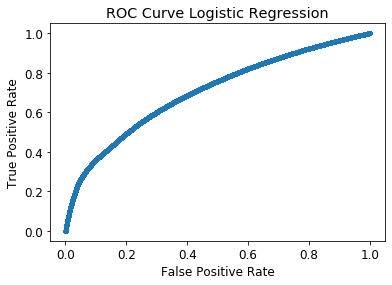

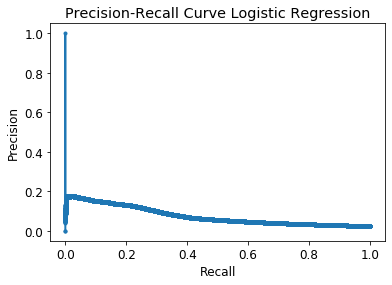

In [16]:
# Best threshold calculation and areas under the curves 
roc_auc_lr_micro, pr_auc_lr_micro, best_thresh_roc_curve_lr_micro, best_thresh_pr_curve_lr_micro = find_best_threshold(
    predictions_df = results_lr_micro,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Logistic Regression'
)

In [17]:
# Threshold optimization: with ROC Curve best threshold
predict_test_lr_micro = get_optimal_threshold_results(
    predictions_df = predict_test_lr_micro, 
    threshold = best_thresh_roc_curve_lr_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_lr_micro = get_optimal_threshold_results(
    predictions_df = predict_test_lr_micro, 
    threshold = best_thresh_pr_curve_lr_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [18]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_lr_micro = conpute_confusion_matrix(predict_test_lr_micro, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_lr_micro = conpute_confusion_matrix(predict_test_lr_micro, 'prediction_pr_th', 'label')

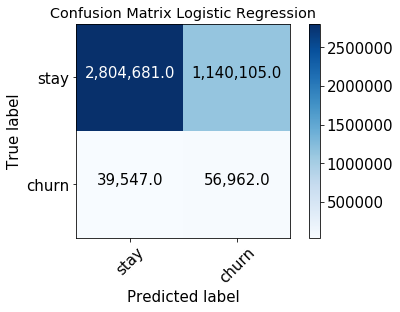

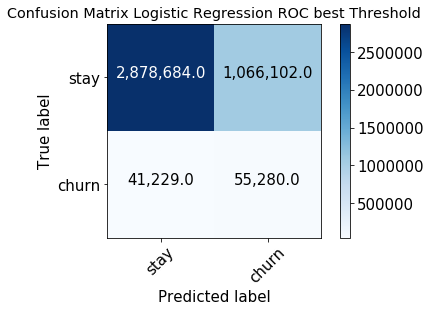

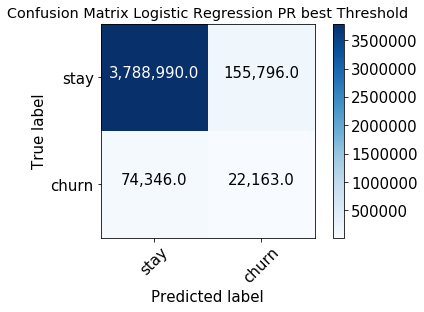

In [19]:
# Evaluation metrics calculation
precision_lr_micro, recall_lr_micro, fscore_lr_micro = evaluate_model(
    confusion_matrix = cm_lr_micro,  
    model_name = 'Logistic Regression'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_lr_micro, recall_roc_lr_micro, fscore_roc_lr_micro = evaluate_model(
    confusion_matrix = cm_roc_lr_micro,
    model_name = 'Logistic Regression ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_lr_micro, recall_pr_lr_micro, fscore_pr_lr_micro = evaluate_model(
    confusion_matrix = cm_pr_lr_micro,
    model_name = 'Logistic Regression PR best Threshold'
)

In [20]:
#Displaying Evaluation metrics as pandas dataframe
metrics_lr_micro = metrics_to_pandas(
    model = 'Logistic Regression Micro',
    precision = precision_lr_micro, 
    recall = recall_lr_micro, 
    fscore = fscore_lr_micro, 
    roc_auc = roc_auc_lr_micro, 
    pr_auc = pr_auc_lr_micro
)
print("Metrics before threshold optimization: ")
display(metrics_lr_micro)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_lr_micro = metrics_to_pandas(
    model = 'Logistic Regression Micro',
    precision = precision_roc_lr_micro, 
    recall = recall_roc_lr_micro, 
    fscore = fscore_roc_lr_micro, 
    roc_auc = roc_auc_lr_micro, 
    pr_auc = pr_auc_lr_micro,
    roc_best_threshold = best_thresh_roc_curve_lr_micro
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_lr_micro = metrics_to_pandas(
    model = 'Logistic Regression Micro',
    precision = precision_pr_lr_micro, 
    recall = recall_pr_lr_micro, 
    fscore = fscore_pr_lr_micro, 
    roc_auc = roc_auc_lr_micro, 
    pr_auc = pr_auc_lr_micro,
    pr_best_threshold = best_thresh_pr_curve_lr_micro
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_lr_micro)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_lr_micro)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.5,4.75846,59.0225,8.8069,0.704211,0.0756913


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.5076,4.92963,57.2796,9.07799,0.704211,0.0756913


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.734524,12.454,22.9647,16.1498,0.704211,0.0756913


In [21]:
metrics_perc_dict_micro['Model'].append('Logistic Regression Micro')
metrics_perc_dict_micro['Default Threshold'].append(0.5)
metrics_perc_dict_micro['Precision (%)'].append(precision_lr_micro*100)
metrics_perc_dict_micro['Recall (%)'].append(recall_lr_micro*100)
metrics_perc_dict_micro['F1 Score (%)'].append(fscore_lr_micro*100)
metrics_perc_dict_micro['ROC AUC'].append(roc_auc_lr_micro)
metrics_perc_dict_micro['PR AUC'].append(pr_auc_lr_micro)

metrics_perc_dict_roc_th_micro['Model'].append('Logistic Regression Micro')
metrics_perc_dict_roc_th_micro['ROC Best Threshold'].append(best_thresh_roc_curve_lr_micro)
metrics_perc_dict_roc_th_micro['Precision (%)'].append(precision_roc_lr_micro*100)
metrics_perc_dict_roc_th_micro['Recall (%)'].append(recall_roc_lr_micro*100)
metrics_perc_dict_roc_th_micro['F1 Score (%)'].append(fscore_roc_lr_micro*100)
metrics_perc_dict_roc_th_micro['ROC AUC'].append(roc_auc_lr_micro)
metrics_perc_dict_roc_th_micro['PR AUC'].append(pr_auc_lr_micro)

metrics_perc_dict_pr_th_micro['Model'].append('Logistic Regression Micro')
metrics_perc_dict_pr_th_micro['PR Best Threshold'].append(best_thresh_pr_curve_lr_micro)
metrics_perc_dict_pr_th_micro['Precision (%)'].append(precision_pr_lr_micro*100)
metrics_perc_dict_pr_th_micro['Recall (%)'].append(recall_pr_lr_micro*100)
metrics_perc_dict_pr_th_micro['F1 Score (%)'].append(fscore_pr_lr_micro*100)
metrics_perc_dict_pr_th_micro['ROC AUC'].append(roc_auc_lr_micro)
metrics_perc_dict_pr_th_micro['PR AUC'].append(pr_auc_lr_micro)

### Random forest classifier

A random forest is a machine learning classification algorithm. Random forests are generated collections of decision trees.

#### Building

In [22]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from time import *

In [23]:
rf_micro = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rf_model_micro = rf_micro.fit(assembled_train_set_micro)
predict_train_rf_micro = rf_model_micro.transform(assembled_train_set_micro)
predict_test_rf_micro = rf_model_micro.transform(assembled_test_set_micro)

In [24]:
predict_test_rf_micro = split_proba_column(predictions_df = predict_test_rf_micro, proba_col = 'probability')
cm_rf_micro = conpute_confusion_matrix(predict_test_rf_micro, 'prediction', 'label')
results_rf_micro = predict_test_rf_micro.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

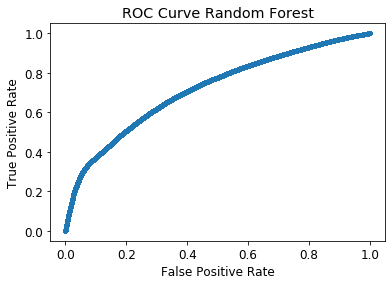

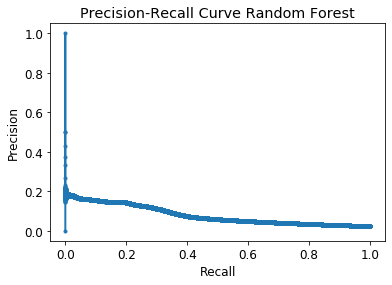

In [25]:
# Best threshold calculation and areas under the curves 
roc_auc_rf_micro, pr_auc_rf_micro, best_thresh_roc_curve_rf_micro, best_thresh_pr_curve_rf_micro = find_best_threshold(
    predictions_df = results_rf_micro,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Random Forest'
)

In [26]:
# Threshold optimization: with ROC Curve best threshold
predict_test_rf_micro = get_optimal_threshold_results(
    predictions_df = predict_test_rf_micro, 
    threshold = best_thresh_roc_curve_rf_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_rf_micro = get_optimal_threshold_results(
    predictions_df = predict_test_rf_micro, 
    threshold = best_thresh_pr_curve_rf_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [27]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_rf_micro = conpute_confusion_matrix(predict_test_rf_micro, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_rf_micro = conpute_confusion_matrix(predict_test_rf_micro, 'prediction_pr_th', 'label')

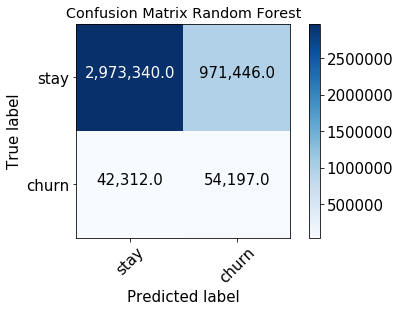

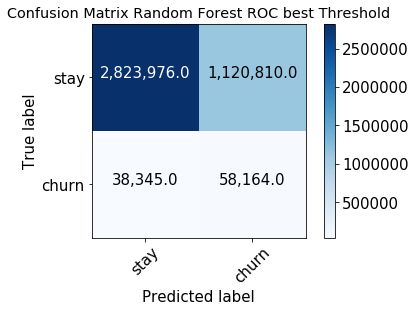

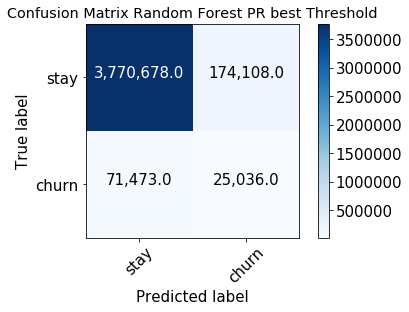

In [28]:
# Evaluation metrics calculation
precision_rf_micro, recall_rf_micro, fscore_rf_micro = evaluate_model(
    confusion_matrix = cm_rf_micro,  
    model_name = 'Random Forest'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_rf_micro, recall_roc_rf_micro, fscore_roc_rf_micro = evaluate_model(
    confusion_matrix = cm_roc_rf_micro,
    model_name = 'Random Forest ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_rf_micro, recall_pr_rf_micro, fscore_pr_rf_micro = evaluate_model(
    confusion_matrix = cm_pr_rf_micro,
    model_name = 'Random Forest PR best Threshold'
)

In [29]:
#Displaying Evaluation metrics as pandas dataframe
metrics_rf_micro = metrics_to_pandas(
    model = 'Random Forest Micro',
    precision = precision_rf_micro, 
    recall = recall_rf_micro, 
    fscore = fscore_rf_micro, 
    roc_auc = roc_auc_rf_micro, 
    pr_auc = pr_auc_rf_micro
)
print("Metrics before threshold optimization: ")
display(metrics_rf_micro)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_rf_micro = metrics_to_pandas(
    model = 'Random Forest Micro',
    precision = precision_roc_rf_micro, 
    recall = recall_roc_rf_micro, 
    fscore = fscore_roc_rf_micro, 
    roc_auc = roc_auc_rf_micro, 
    pr_auc = pr_auc_rf_micro,
    roc_best_threshold = best_thresh_roc_curve_rf_micro
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_rf_micro = metrics_to_pandas(
    model = 'Random Forest Micro',
    precision = precision_pr_rf_micro, 
    recall = recall_pr_rf_micro, 
    fscore = fscore_pr_rf_micro, 
    roc_auc = roc_auc_rf_micro, 
    pr_auc = pr_auc_rf_micro,
    pr_best_threshold = best_thresh_pr_curve_rf_micro
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_rf_micro)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_rf_micro)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Micro,0.5,5.2842,56.1575,9.65948,0.716906,0.0798355


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Micro,0.490283,4.93344,60.268,9.12031,0.716906,0.0798355


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Micro,0.567601,12.5718,25.9416,16.9361,0.716906,0.0798355


In [30]:
metrics_perc_dict_micro['Model'].append('Random Forest Micro')
metrics_perc_dict_micro['Default Threshold'].append(0.5)
metrics_perc_dict_micro['Precision (%)'].append(precision_rf_micro*100)
metrics_perc_dict_micro['Recall (%)'].append(recall_rf_micro*100)
metrics_perc_dict_micro['F1 Score (%)'].append(fscore_rf_micro*100)
metrics_perc_dict_micro['ROC AUC'].append(roc_auc_rf_micro)
metrics_perc_dict_micro['PR AUC'].append(pr_auc_rf_micro)

metrics_perc_dict_roc_th_micro['Model'].append('Random Forest Micro')
metrics_perc_dict_roc_th_micro['ROC Best Threshold'].append(best_thresh_roc_curve_rf_micro)
metrics_perc_dict_roc_th_micro['Precision (%)'].append(precision_roc_rf_micro*100)
metrics_perc_dict_roc_th_micro['Recall (%)'].append(recall_roc_rf_micro*100)
metrics_perc_dict_roc_th_micro['F1 Score (%)'].append(fscore_roc_rf_micro*100)
metrics_perc_dict_roc_th_micro['ROC AUC'].append(roc_auc_rf_micro)
metrics_perc_dict_roc_th_micro['PR AUC'].append(pr_auc_rf_micro)

metrics_perc_dict_pr_th_micro['Model'].append('Random Forest Micro')
metrics_perc_dict_pr_th_micro['PR Best Threshold'].append(best_thresh_pr_curve_rf_micro)
metrics_perc_dict_pr_th_micro['Precision (%)'].append(precision_pr_rf_micro*100)
metrics_perc_dict_pr_th_micro['Recall (%)'].append(recall_pr_rf_micro*100)
metrics_perc_dict_pr_th_micro['F1 Score (%)'].append(fscore_pr_rf_micro*100)
metrics_perc_dict_pr_th_micro['ROC AUC'].append(roc_auc_rf_micro)
metrics_perc_dict_pr_th_micro['PR AUC'].append(pr_auc_rf_micro)

## Decision tree classifier

#### Building

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel

In [32]:
dt_micro = dt_micro = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model_micro = dt_micro.fit(assembled_train_set_micro)
predict_train_dt_micro = dt_model_micro.transform(assembled_train_set_micro)
predict_test_dt_micro = dt_model_micro.transform(assembled_test_set_micro)

In [33]:
predict_test_dt_micro = split_proba_column(predictions_df = predict_test_dt_micro, proba_col = 'probability')
cm_dt_micro = conpute_confusion_matrix(predict_test_dt_micro, 'prediction', 'label')
results_dt_micro = predict_test_dt_micro.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

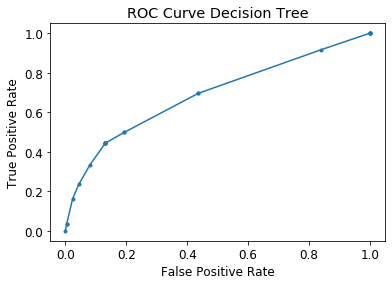

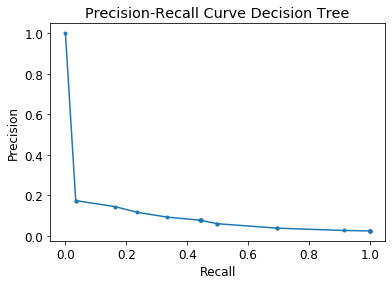

In [34]:
# Best threshold calculation and areas under the curves 
roc_auc_dt_micro, pr_auc_dt_micro, best_thresh_roc_curve_dt_micro, best_thresh_pr_curve_dt_micro = find_best_threshold(
    predictions_df = results_dt_micro,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Decision Tree'
)

In [35]:
# Threshold optimization: with ROC Curve best threshold
predict_test_dt_micro = get_optimal_threshold_results(
    predictions_df = predict_test_dt_micro, 
    threshold = best_thresh_roc_curve_dt_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_dt_micro = get_optimal_threshold_results(
    predictions_df = predict_test_dt_micro, 
    threshold = best_thresh_pr_curve_dt_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [36]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_dt_micro = conpute_confusion_matrix(predict_test_dt_micro, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_dt_micro = conpute_confusion_matrix(predict_test_dt_micro, 'prediction_pr_th', 'label')

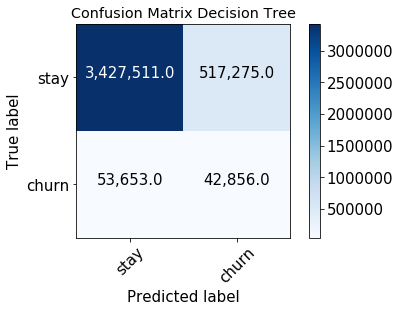

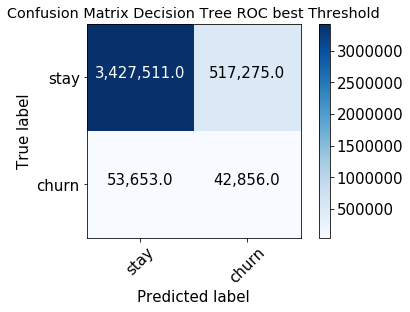

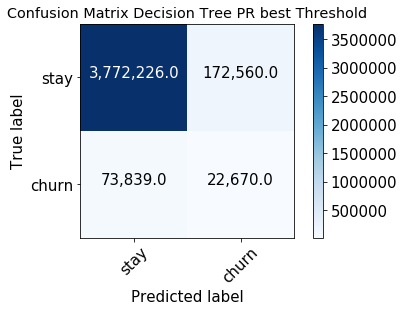

In [37]:
# Evaluation metrics calculation
precision_dt_micro, recall_dt_micro, fscore_dt_micro = evaluate_model(
    confusion_matrix = cm_dt_micro,  
    model_name = 'Decision Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_dt_micro, recall_roc_dt_micro, fscore_roc_dt_micro = evaluate_model(
    confusion_matrix = cm_roc_dt_micro,
    model_name = 'Decision Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_dt_micro, recall_pr_dt_micro, fscore_pr_dt_micro = evaluate_model(
    confusion_matrix = cm_pr_dt_micro,
    model_name = 'Decision Tree PR best Threshold'
)

In [38]:
#Displaying Evaluation metrics as pandas dataframe
metrics_dt_micro = metrics_to_pandas(
    model = 'Decision Tree Micro',
    precision = precision_dt_micro, 
    recall = recall_dt_micro, 
    fscore = fscore_dt_micro, 
    roc_auc = roc_auc_dt_micro, 
    pr_auc = pr_auc_dt_micro
)
print("Metrics before threshold optimization: ")
display(metrics_dt_micro)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_dt_micro = metrics_to_pandas(
    model = 'Decision Tree Micro',
    precision = precision_roc_dt_micro, 
    recall = recall_roc_dt_micro, 
    fscore = fscore_roc_dt_micro, 
    roc_auc = roc_auc_dt_micro, 
    pr_auc = pr_auc_dt_micro,
    roc_best_threshold = best_thresh_roc_curve_dt_micro
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_dt_micro = metrics_to_pandas(
    model = 'Decision Tree Micro',
    precision = precision_pr_dt_micro, 
    recall = recall_pr_dt_micro, 
    fscore = fscore_pr_dt_micro, 
    roc_auc = roc_auc_dt_micro, 
    pr_auc = pr_auc_dt_micro,
    pr_best_threshold = best_thresh_pr_curve_dt_micro
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_dt_micro)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_dt_micro)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Micro,0.5,7.65107,44.4062,13.0531,0.689376,0.0916564


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Micro,0.540309,7.65107,44.4062,13.0531,0.689376,0.0916564


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Micro,0.773542,11.6119,23.49,15.5413,0.689376,0.0916564


In [39]:
metrics_perc_dict_micro['Model'].append('Decision Tree Micro')
metrics_perc_dict_micro['Default Threshold'].append(0.5)
metrics_perc_dict_micro['Precision (%)'].append(precision_dt_micro*100)
metrics_perc_dict_micro['Recall (%)'].append(recall_dt_micro*100)
metrics_perc_dict_micro['F1 Score (%)'].append(fscore_dt_micro*100)
metrics_perc_dict_micro['ROC AUC'].append(roc_auc_dt_micro)
metrics_perc_dict_micro['PR AUC'].append(pr_auc_dt_micro)

metrics_perc_dict_roc_th_micro['Model'].append('Decision Tree Micro')
metrics_perc_dict_roc_th_micro['ROC Best Threshold'].append(best_thresh_roc_curve_dt_micro)
metrics_perc_dict_roc_th_micro['Precision (%)'].append(precision_roc_dt_micro*100)
metrics_perc_dict_roc_th_micro['Recall (%)'].append(recall_roc_dt_micro*100)
metrics_perc_dict_roc_th_micro['F1 Score (%)'].append(fscore_roc_dt_micro*100)
metrics_perc_dict_roc_th_micro['ROC AUC'].append(roc_auc_dt_micro)
metrics_perc_dict_roc_th_micro['PR AUC'].append(pr_auc_dt_micro)

metrics_perc_dict_pr_th_micro['Model'].append('Decision Tree Micro')
metrics_perc_dict_pr_th_micro['PR Best Threshold'].append(best_thresh_pr_curve_dt_micro)
metrics_perc_dict_pr_th_micro['Precision (%)'].append(precision_pr_dt_micro*100)
metrics_perc_dict_pr_th_micro['Recall (%)'].append(recall_pr_dt_micro*100)
metrics_perc_dict_pr_th_micro['F1 Score (%)'].append(fscore_pr_dt_micro*100)
metrics_perc_dict_pr_th_micro['ROC AUC'].append(roc_auc_dt_micro)
metrics_perc_dict_pr_th_micro['PR AUC'].append(pr_auc_dt_micro)

## Gradient-boosted tree classifier

#### Building

In [40]:
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel

In [41]:
gbt_micro = GBTClassifier(labelCol='label', featuresCol="features", maxIter=50)
gbt_model_micro = gbt_micro.fit(assembled_train_set_micro)
predict_train_gbt_micro = gbt_model_micro.transform(assembled_train_set_micro)
predict_test_gbt_micro = gbt_model_micro.transform(assembled_test_set_micro)

In [42]:
predict_test_gbt_micro = split_proba_column(predictions_df = predict_test_gbt_micro, proba_col = 'probability')
cm_gbt_micro = conpute_confusion_matrix(predict_test_gbt_micro, 'prediction', 'label')
results_gbt_micro = predict_test_gbt_micro.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

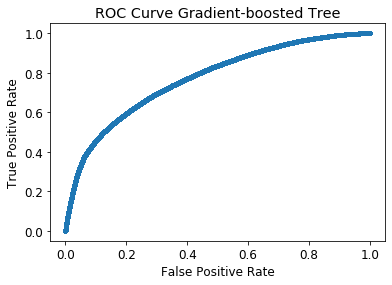

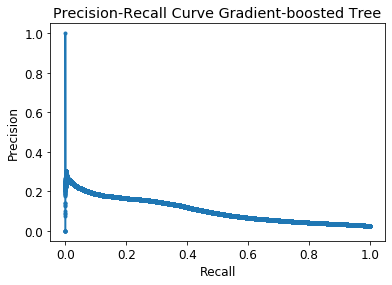

In [43]:
# Best threshold calculation and areas under the curves 
roc_auc_gbt_micro, pr_auc_gbt_micro, best_thresh_roc_curve_gbt_micro, best_thresh_pr_curve_gbt_micro = find_best_threshold(
    predictions_df = results_gbt_micro,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Gradient-boosted Tree'
)

In [44]:
# Threshold optimization: with ROC Curve best threshold
predict_test_gbt_micro = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_micro, 
    threshold = best_thresh_roc_curve_gbt_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_gbt_micro = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_micro, 
    threshold = best_thresh_pr_curve_gbt_micro,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [45]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_gbt_micro = conpute_confusion_matrix(predict_test_gbt_micro, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_gbt_micro = conpute_confusion_matrix(predict_test_gbt_micro, 'prediction_pr_th', 'label')

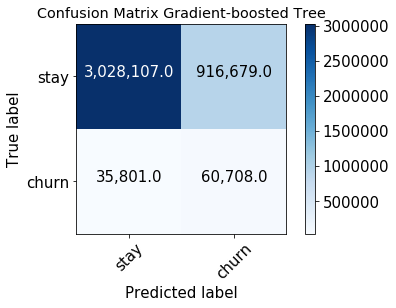

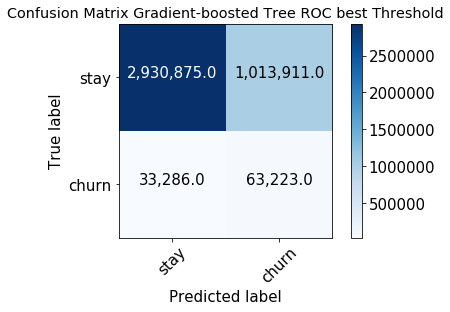

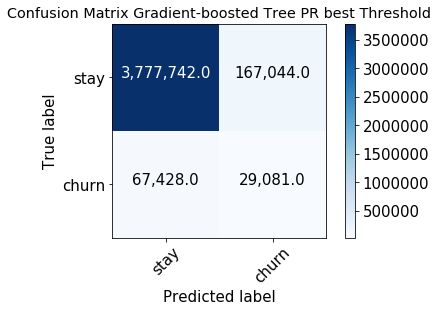

In [46]:
# Evaluation metrics calculation
precision_gbt_micro, recall_gbt_micro, fscore_gbt_micro = evaluate_model(
    confusion_matrix = cm_gbt_micro,  
    model_name = 'Gradient-boosted Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_gbt_micro, recall_roc_gbt_micro, fscore_roc_gbt_micro = evaluate_model(
    confusion_matrix = cm_roc_gbt_micro,
    model_name = 'Gradient-boosted Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_gbt_micro, recall_pr_gbt_micro, fscore_pr_gbt_micro = evaluate_model(
    confusion_matrix = cm_pr_gbt_micro,
    model_name = 'Gradient-boosted Tree PR best Threshold'
)

In [47]:
#Displaying Evaluation metrics as pandas dataframe
metrics_gbt_micro = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro',
    precision = precision_gbt_micro, 
    recall = recall_gbt_micro, 
    fscore = fscore_gbt_micro, 
    roc_auc = roc_auc_gbt_micro, 
    pr_auc = pr_auc_gbt_micro
)
print("Metrics before threshold optimization: ")
display(metrics_gbt_micro)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_gbt_micro = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro',
    precision = precision_roc_gbt_micro, 
    recall = recall_roc_gbt_micro, 
    fscore = fscore_roc_gbt_micro, 
    roc_auc = roc_auc_gbt_micro, 
    pr_auc = pr_auc_gbt_micro,
    roc_best_threshold = best_thresh_roc_curve_gbt_micro
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_gbt_micro = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro',
    precision = precision_pr_gbt_micro, 
    recall = recall_pr_gbt_micro, 
    fscore = fscore_pr_gbt_micro, 
    roc_auc = roc_auc_gbt_micro, 
    pr_auc = pr_auc_gbt_micro,
    pr_best_threshold = best_thresh_pr_curve_gbt_micro
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_gbt_micro)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_gbt_micro)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro,0.5,6.21126,62.904,11.3061,0.772177,0.104269


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro,0.485099,5.86956,65.51,10.7738,0.772177,0.104269


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro,0.772807,14.8278,30.1329,19.8753,0.772177,0.104269


In [48]:
metrics_perc_dict_micro['Model'].append('Gradient-boosted Tree Micro')
metrics_perc_dict_micro['Default Threshold'].append(0.5)
metrics_perc_dict_micro['Precision (%)'].append(precision_gbt_micro*100)
metrics_perc_dict_micro['Recall (%)'].append(recall_gbt_micro*100)
metrics_perc_dict_micro['F1 Score (%)'].append(fscore_gbt_micro*100)
metrics_perc_dict_micro['ROC AUC'].append(roc_auc_gbt_micro)
metrics_perc_dict_micro['PR AUC'].append(pr_auc_gbt_micro)

metrics_perc_dict_roc_th_micro['Model'].append('Gradient-boosted Tree Micro')
metrics_perc_dict_roc_th_micro['ROC Best Threshold'].append(best_thresh_roc_curve_gbt_micro)
metrics_perc_dict_roc_th_micro['Precision (%)'].append(precision_roc_gbt_micro*100)
metrics_perc_dict_roc_th_micro['Recall (%)'].append(recall_roc_gbt_micro*100)
metrics_perc_dict_roc_th_micro['F1 Score (%)'].append(fscore_roc_gbt_micro*100)
metrics_perc_dict_roc_th_micro['ROC AUC'].append(roc_auc_gbt_micro)
metrics_perc_dict_roc_th_micro['PR AUC'].append(pr_auc_gbt_micro)

metrics_perc_dict_pr_th_micro['Model'].append('Gradient-boosted Tree Micro')
metrics_perc_dict_pr_th_micro['PR Best Threshold'].append(best_thresh_pr_curve_gbt_micro)
metrics_perc_dict_pr_th_micro['Precision (%)'].append(precision_pr_gbt_micro*100)
metrics_perc_dict_pr_th_micro['Recall (%)'].append(recall_pr_gbt_micro*100)
metrics_perc_dict_pr_th_micro['F1 Score (%)'].append(fscore_pr_gbt_micro*100)
metrics_perc_dict_pr_th_micro['ROC AUC'].append(roc_auc_gbt_micro)
metrics_perc_dict_pr_th_micro['PR AUC'].append(pr_auc_gbt_micro)

### XGBoost

In [49]:
from pysparkling.ml import H2OXGBoost
from h2o.estimators.xgboost import H2OXGBoostEstimator
from pysparkling import *
import h2o

In [50]:
hc = None

In [51]:
if hc is None:
    conf = H2OConf().set('spark.dynamicAllocation.enabled', False).setInternalClusterMode()
    # Default value True causes this error:  IllegalArgumentException: 'Unsupported argument: (spark.dynamicAllocation.enabled,true)'
    hc = H2OContext.getOrCreate(conf)

Connecting to H2O server at http://10.151.52.14:54321 ... successful.


H2O_cluster_uptime:,12 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,4 months and 6 days !!!
H2O_cluster_name:,sparkling-water-anxadvuser_application_1600061706586_174332
H2O_cluster_total_nodes:,4
H2O_cluster_free_memory:,56.89 Gb
H2O_cluster_total_cores:,128
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.4-1-2.4
 * H2O name: anxadvuser
 * cluster size: 4
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.151.52.14,54321)
  (1,10.151.52.14,54323)
  (2,10.151.52.14,54325)
  (3,10.151.52.14,54327)
  ------------------------

  Open H2O Flow in browser: http://claawme2ba29.enelint.global:54323 (CMD + click in Mac OSX)

    
 * Yarn App ID of Spark application: application_1600061706586_174332
    


#### Building

In [52]:
xgb_micro = H2OXGBoost(
    quietMode=True,
    ntrees=50,
    maxDepth=6,
    minRows=1.0,
    minChildWeight=1.0,
    learnRate=0.02,
    sampleRate=1.0,
    subsample=1.0,
    colSampleRate=1.0,
    colSampleByLevel=1.0,
    colSampleRatePerTree=0.7,
    colSampleByTree=1.0,
    maxAbsLeafnodePred=0.0,
    maxDeltaStep=0.0,
    scoreTreeInterval=0,
    minSplitImprovement=0.0,
    gamma=0.0,
    nthread=-1,
    maxBins=256,
    maxLeaves=0,
    treeMethod="hist",
    growPolicy="lossguide",
    booster="gbtree",
    dmatrixType="auto",
    regLambda=0.0,
    regAlpha=0.0,
    sampleType="uniform",
    normalizeType="tree",
    rateDrop=0.0,
    oneDrop=False,
    skipDrop=0.0,
    gpuId=0,
    backend="auto",
    modelId=None,
    keepCrossValidationPredictions=False,
    keepCrossValidationFoldAssignment=False,
    parallelizeCrossValidation=True,
    distribution="AUTO",
    labelCol=labelCol,              # TARGET FEATURE
    featuresCols=train_set_assembled_col_names_micro, # TRAIN FEATURES
    foldCol=None,
    weightCol=None,
    offsetCol=None,
    splitRatio=1.0,
    seed=-1,
    nfolds=0,
    columnsToCategorical=[],
    predictionCol="prediction",
    detailedPredictionCol="detailed_prediction",
    withDetailedPredictionCol=True,
    convertUnknownCategoricalLevelsToNa=False,
    convertInvalidNumbersToNa=False,
    namedMojoOutputColumns=True,
    monotoneConstraints={},
    stoppingRounds=0,
    stoppingMetric="AUTO",
    stoppingTolerance=0.001,
    withContributions=False
)

In [53]:
xgb_model_micro = xgb_micro.fit(train_set_features_selected_micro)

In [54]:
predict_train_xgb_micro = xgb_model_micro.transform(train_set_features_selected_micro)
predict_test_xgb_micro = xgb_model_micro.transform(test_set_features_selected_micro)

In [55]:
predict_test_xgb_micro = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_micro, 
    threshold = 0.5,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label'
)

In [56]:
cm_xgb_micro = conpute_confusion_matrix(predict_test_xgb_micro, 'predicted_label', labelCol)
results_xgb_micro = predict_test_xgb_micro.select(labelCol, 'prediction', 'predicted_label').toPandas()

#### Evaluation

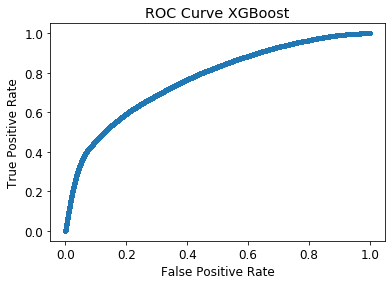

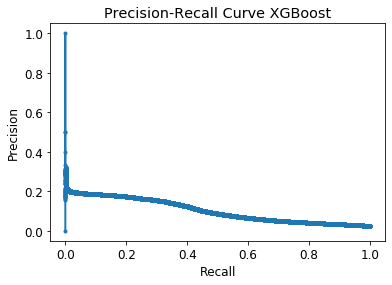

In [57]:
# Best threshold calculation and areas under the curves 
roc_auc_xgb_micro, pr_auc_xgb_micro, best_thresh_roc_curve_xgb_micro, best_thresh_pr_curve_xgb_micro = find_best_threshold(
    predictions_df = results_xgb_micro,
    label_col = labelCol,
    churn_proba_col = 'prediction',
    model_name = 'XGBoost'
)

In [58]:
# Threshold optimization: with ROC Curve best threshold
predict_test_xgb_micro = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_micro, 
    threshold = best_thresh_roc_curve_xgb_micro,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_xgb_micro = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_micro, 
    threshold = best_thresh_pr_curve_xgb_micro,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label_pr_th'
)

In [59]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_xgb_micro = conpute_confusion_matrix(predict_test_xgb_micro, 'predicted_label_roc_th', labelCol)

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_xgb_micro = conpute_confusion_matrix(predict_test_xgb_micro, 'predicted_label_pr_th', labelCol)

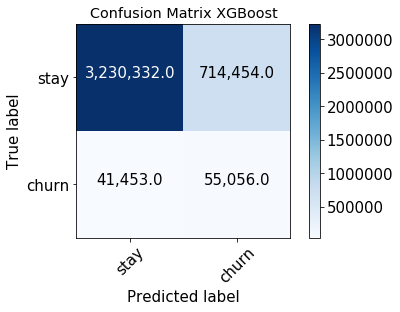

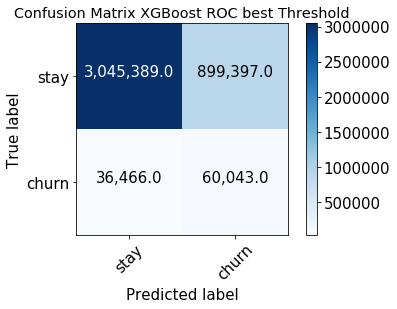

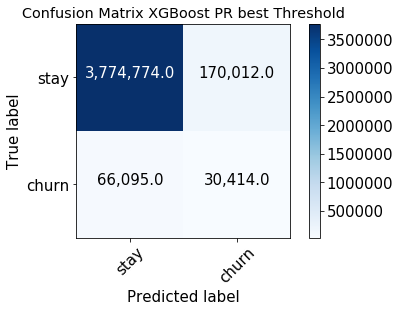

In [60]:
# Evaluation metrics calculation
precision_xgb_micro, recall_xgb_micro, fscore_xgb_micro = evaluate_model(
    confusion_matrix = cm_xgb_micro,  
    model_name = 'XGBoost'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_xgb_micro, recall_roc_xgb_micro, fscore_roc_xgb_micro = evaluate_model(
    confusion_matrix = cm_roc_xgb_micro,
    model_name = 'XGBoost ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_xgb_micro, recall_pr_xgb_micro, fscore_pr_xgb_micro = evaluate_model(
    confusion_matrix = cm_pr_xgb_micro,
    model_name = 'XGBoost PR best Threshold'
)

In [61]:
#Displaying Evaluation metrics as pandas dataframe
metrics_xgb_micro = metrics_to_pandas(
    model = 'XGBoost Micro',
    precision = precision_xgb_micro, 
    recall = recall_xgb_micro, 
    fscore = fscore_xgb_micro, 
    roc_auc = roc_auc_xgb_micro, 
    pr_auc = pr_auc_xgb_micro
)
print("Metrics before threshold optimization: ")
display(metrics_xgb_micro)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_xgb_micro = metrics_to_pandas(
    model = 'XGBoost Micro',
    precision = precision_roc_xgb_micro, 
    recall = recall_roc_xgb_micro, 
    fscore = fscore_roc_xgb_micro, 
    roc_auc = roc_auc_xgb_micro, 
    pr_auc = pr_auc_xgb_micro,
    roc_best_threshold = best_thresh_roc_curve_xgb_micro
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_xgb_micro = metrics_to_pandas(
    model = 'XGBoost Micro',
    precision = precision_pr_xgb_micro, 
    recall = recall_pr_xgb_micro, 
    fscore = fscore_pr_xgb_micro, 
    roc_auc = roc_auc_xgb_micro, 
    pr_auc = pr_auc_xgb_micro,
    pr_best_threshold = best_thresh_pr_curve_xgb_micro
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_xgb_micro)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_xgb_micro)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Micro,0.5,7.15468,57.0475,12.7147,0.769127,0.103214


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Micro,0.489229,6.25813,62.2149,11.3723,0.769127,0.103214


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Micro,0.615333,15.1747,31.5142,20.4853,0.769127,0.103214


In [62]:
metrics_perc_dict_micro['Model'].append('XGBoost Micro')
metrics_perc_dict_micro['Default Threshold'].append(0.5)
metrics_perc_dict_micro['Precision (%)'].append(precision_xgb_micro*100)
metrics_perc_dict_micro['Recall (%)'].append(recall_xgb_micro*100)
metrics_perc_dict_micro['F1 Score (%)'].append(fscore_xgb_micro*100)
metrics_perc_dict_micro['ROC AUC'].append(roc_auc_xgb_micro)
metrics_perc_dict_micro['PR AUC'].append(pr_auc_xgb_micro)

metrics_perc_dict_roc_th_micro['Model'].append('XGBoost Micro')
metrics_perc_dict_roc_th_micro['ROC Best Threshold'].append(best_thresh_roc_curve_xgb_micro)
metrics_perc_dict_roc_th_micro['Precision (%)'].append(precision_roc_xgb_micro*100)
metrics_perc_dict_roc_th_micro['Recall (%)'].append(recall_roc_xgb_micro*100)
metrics_perc_dict_roc_th_micro['F1 Score (%)'].append(fscore_roc_xgb_micro*100)
metrics_perc_dict_roc_th_micro['ROC AUC'].append(roc_auc_xgb_micro)
metrics_perc_dict_roc_th_micro['PR AUC'].append(pr_auc_xgb_micro)

metrics_perc_dict_pr_th_micro['Model'].append('XGBoost Micro')
metrics_perc_dict_pr_th_micro['PR Best Threshold'].append(best_thresh_pr_curve_xgb_micro)
metrics_perc_dict_pr_th_micro['Precision (%)'].append(precision_pr_xgb_micro*100)
metrics_perc_dict_pr_th_micro['Recall (%)'].append(recall_pr_xgb_micro*100)
metrics_perc_dict_pr_th_micro['F1 Score (%)'].append(fscore_pr_xgb_micro*100)
metrics_perc_dict_pr_th_micro['ROC AUC'].append(roc_auc_xgb_micro)
metrics_perc_dict_pr_th_micro['PR AUC'].append(pr_auc_xgb_micro)

# Summary

In [63]:
display(pd.DataFrame.from_dict(metrics_perc_dict_micro, orient='index').transpose())
display(pd.DataFrame.from_dict(metrics_perc_dict_roc_th_micro, orient='index').transpose())
display(pd.DataFrame.from_dict(metrics_perc_dict_pr_th_micro, orient='index').transpose())

,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.5,4.75846,59.0225,8.8069,0.704211,0.0756913
1,Random Forest Micro,0.5,5.2842,56.1575,9.65948,0.716906,0.0798355
2,Decision Tree Micro,0.5,7.65107,44.4062,13.0531,0.689376,0.0916564
3,Gradient-boosted Tree Micro,0.5,6.21126,62.904,11.3061,0.772177,0.104269
4,XGBoost Micro,0.5,7.15468,57.0475,12.7147,0.769127,0.103214


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.5076,4.92963,57.2796,9.07799,0.704211,0.0756913
1,Random Forest Micro,0.490283,4.93344,60.268,9.12031,0.716906,0.0798355
2,Decision Tree Micro,0.540309,7.65107,44.4062,13.0531,0.689376,0.0916564
3,Gradient-boosted Tree Micro,0.485099,5.86956,65.51,10.7738,0.772177,0.104269
4,XGBoost Micro,0.489229,6.25813,62.2149,11.3723,0.769127,0.103214


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Micro,0.734524,12.454,22.9647,16.1498,0.704211,0.0756913
1,Random Forest Micro,0.567601,12.5718,25.9416,16.9361,0.716906,0.0798355
2,Decision Tree Micro,0.773542,11.6119,23.49,15.5413,0.689376,0.0916564
3,Gradient-boosted Tree Micro,0.772807,14.8278,30.1329,19.8753,0.772177,0.104269
4,XGBoost Micro,0.615333,15.1747,31.5142,20.4853,0.769127,0.103214


# Best model optimization: Gradient-boosted Tree

In [11]:
# Function that returns a random point of the exploration surface:
import random
import math

# maxDepth: Maximum depth of the tree (>= 0)
# maxBins: Maximum number of bins used for discretizing continuous features 
#          and for choosing how to split on features at each node. More bins give higher 
#          granularity. Must be >= 2 and >= number of categories in any categorical feature.
# maxIter: Param for maximum number of iterations (>= 0).
# stepSize: Param for Step size to be used for each iteration of optimization.
# lossType: Loss function which GBT tries to minimize. For classification, must be "logistic". 
#           For regression, must be one of "squared" (L2) and "absolute" (L1), default is "squared".
# seed: integer seed for random number generation.
# subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]
# minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes 
#                      the left or right child to have fewer than minInstancesPerNode, the split will 
#                      be discarded as invalid. Should be >= 1.
# minInfoGain: Minimum information gain for a split to be considered at a tree node.
# checkpointInterval: Param for set checkpoint interval (>= 1) or disable checkpoint (-1).

# Default values
#featuresCol="features", labelCol="label", predictionCol="prediction",
#maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
#maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic",
#maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0


def generate_random_configuration():
    params = {
        'maxDepth': math.floor(random.uniform(1, 30)),
        'maxBins': math.floor(random.uniform(2, 50)),
        'minInstancesPerNode': math.floor(random.uniform(1, 10)),
        'checkpointInterval': math.floor(random.uniform(1, 50)),
        'maxIter': math.floor(random.uniform(50, 100)),
        'stepSize': random.uniform(0.01, 1.0),
        'subsamplingRate': random.uniform(0.01, 1)
    }
    return params

#### Building

In [12]:
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel 
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [4]:
used_params = []
#pr_auc_per_iter = []
#params_per_iter = []

with open(os.getcwd()+"/random_search/pr_auc_per_iter_micro.pickle", 'rb') as file:
    pr_auc_per_iter = pickle.load(file)
    
with open(os.getcwd()+"/random_search/params_per_iter_micro.pickle", 'rb') as file:
    params_per_iter = pickle.load(file)

for params in params_per_iter:
    params_list = [
        params['maxDepth'], params['maxBins'], params['minInstancesPerNode'], 
        params['checkpointInterval'], params['maxIter'],
        params['stepSize'], params['subsamplingRate']
    ]
    used_params.append(params_list)

In [5]:
pr_auc_per_iter

[0.08413664766968339,
 0.12483933407814685,
 0.12397118219672694,
 0.109152444484818,
 0.07029680540067734,
 0.05625509728509282,
 0.047196506330461775,
 0.09121290561048437,
 0.09268336549105442,
 0.0604388469278744,
 0.1933980215346917,
 0.09446882837947937,
 0.09813554758851557,
 0.09625107891165245,
 0.09218446868874232,
 0.08296005415400114,
 0.09546079402945419,
 0.10718055652402449]

In [37]:
import time

In [ ]:
timeout_start = time.time()
timeout = 25200   # [seconds]
i = 1
while (time.time() < timeout_start + timeout):
    # Generate random parameters
    params = generate_random_configuration()
    print()
    print('Iteration: ', i)
    print(params)
    # Check if the parameters have been used already
    params_list = [
        params['maxDepth'], params['maxBins'], params['minInstancesPerNode'], 
        params['checkpointInterval'], params['maxIter'],
        params['stepSize'], params['subsamplingRate']
        ]
    if (params_list in used_params): pass
    else:
        # If the parameters have not been used, train a GBT model usin those parameters
        gbt_micro_final = GBTClassifier(
            labelCol='label', featuresCol="features", maxDepth = params['maxDepth'], maxBins = params['maxBins'], 
            minInstancesPerNode = params['minInstancesPerNode'], checkpointInterval = params['checkpointInterval'], 
            maxIter = params['maxIter'], stepSize = params['stepSize'], subsamplingRate = params['subsamplingRate']
        )
        gbt_model_micro_final = gbt_micro_final.fit(assembled_train_set_micro)
        predict_test_gbt_micro_final = gbt_model_micro_final.transform(assembled_test_set_micro)
        predict_test_gbt_micro_final = split_proba_column(predictions_df = predict_test_gbt_micro_final, proba_col = 'probability')
        # Evaluate the current model
        predictionAndLabels = predict_test_gbt_micro_final.select('churn_probability', 'label').cache()
        metrics = BinaryClassificationMetrics(predictionAndLabels.rdd)
        
        # Update list of auc and params
        pr_auc = metrics.areaUnderPR
        pr_auc_per_iter.append(pr_auc)
        params_per_iter.append(params)
        
        # Save the current list on the filesystem not to lose them
        with open(os.getcwd()+"/random_search/pr_auc_per_iter_micro.pickle", 'wb') as file:
            pickle.dump(pr_auc_per_iter, file, protocol=pickle.HIGHEST_PROTOCOL)
        
        with open(os.getcwd()+"/random_search/params_per_iter_micro.pickle", 'wb') as file:
            pickle.dump(params_per_iter, file, protocol=pickle.HIGHEST_PROTOCOL)
        
        
        
        used_params.append(params_list)
        print("PR AUC: {}".format(pr_auc))
        
    i = i + 1

In [ ]:
#with open(os.getcwd()+"/random_search/pr_auc_per_iter_micro.pickle", 'rb') as file:
#    pr_auc_per_iter = pickle.load(file)
    
#with open(os.getcwd()+"/random_search/params_per_iter_micro.pickle", 'rb') as file:
#    params_per_iter = pickle.load(file)

In [15]:
max_index = nanargmax(pr_auc_per_iter)
best_params = params_per_iter[max_index]
print('Best PR AUC: {}'.format(pr_auc_per_iter[max_index]))
print('Best Parameters: {}'.format(best_params))

Best PR AUC: 0.1933980215346917
Best Parameters: {'maxDepth': 18, 'maxBins': 10, 'minInstancesPerNode': 9, 'checkpointInterval': 4, 'maxIter': 29, 'stepSize': 0.4656094697539778, 'subsamplingRate': 0.9676665353677678}


### Visualize random search output 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
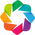

In [6]:
import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh', 'matplotlib')

In [7]:
iterations = [i for i in range(1, len(pr_auc_per_iter) +1)]
random_search_data = pd.DataFrame({'Iteration':iterations,'PR AUC':pr_auc_per_iter})

In [12]:
key_dimensions   = [('Iteration', 'Iteration')]
value_dimensions = [('PR AUC', 'PR AUC')]
pr_auc_data = hv.Table(random_search_data, key_dimensions, value_dimensions)
pr_auc_curves = pr_auc_data.to.curve('Iteration', 'PR AUC')
pr_auc_scatter = pr_auc_data.to.scatter('Iteration', 'PR AUC')

(pr_auc_curves * pr_auc_scatter).opts(
    opts.Curve( color='darkorange' ), 
    opts.Scatter(cmap='RdYlGn', color='PR AUC', line_color='k', size=dim('PR AUC')*100),    
    opts.Overlay(height=500, width=1000, show_frame=False, xrotation= 0, yrotation= 0),
    #plot=dict(width=500, height=500, xrotation= 35),   
)

:Overlay
   .Curve.I   :Curve   [Iteration]   (PR AUC)
   .Scatter.I :Scatter   [Iteration]   (PR AUC)

### Use the best parameters to train the final model

In [16]:
gbt_micro_final = GBTClassifier(
    labelCol='label', featuresCol="features", maxDepth = best_params['maxDepth'], maxBins = best_params['maxBins'], 
    minInstancesPerNode = best_params['minInstancesPerNode'], checkpointInterval = best_params['checkpointInterval'], 
    maxIter = best_params['maxIter'], stepSize = best_params['stepSize'], subsamplingRate = best_params['subsamplingRate']
)

In [17]:
gbt_model_micro_final = gbt_micro_final.fit(assembled_train_set_micro)

In [19]:
predict_test_gbt_micro_final = gbt_model_micro_final.transform(assembled_test_set_micro)

In [18]:
gbt_model_micro_final.save('/bda/anx_adv_achurn/durand/models/gbt_model_micro_final')
#gbt_model_micro_final = GBTClassificationModel.load('/bda/anx_adv_achurn/durand/models/gbt_model_micro_final')

In [20]:
predict_test_gbt_micro_final = split_proba_column(predictions_df = predict_test_gbt_micro_final, proba_col = 'probability')
cm_gbt_micro_final = conpute_confusion_matrix(predict_test_gbt_micro_final, 'prediction', 'label')
results_gbt_micro_final = predict_test_gbt_micro_final.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

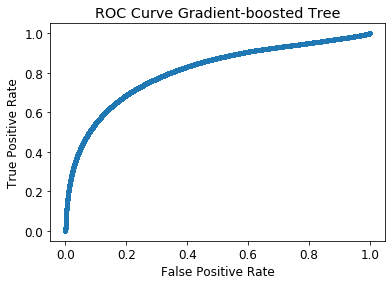

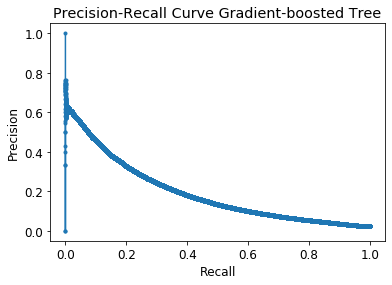

In [21]:
# Best threshold calculation and areas under the curves 
roc_auc_gbt_micro_final, pr_auc_gbt_micro_final, best_thresh_roc_curve_gbt_micro_final, best_thresh_pr_curve_gbt_micro_final = find_best_threshold(
    predictions_df = results_gbt_micro_final,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Gradient-boosted Tree'
)

In [22]:
# Threshold optimization: with ROC Curve best threshold
predict_test_gbt_micro_final = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_micro_final, 
    threshold = best_thresh_roc_curve_gbt_micro_final,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_gbt_micro_final = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_micro_final, 
    threshold = best_thresh_pr_curve_gbt_micro_final,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [23]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_gbt_micro_final = conpute_confusion_matrix(predict_test_gbt_micro_final, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_gbt_micro_final = conpute_confusion_matrix(predict_test_gbt_micro_final, 'prediction_pr_th', 'label')

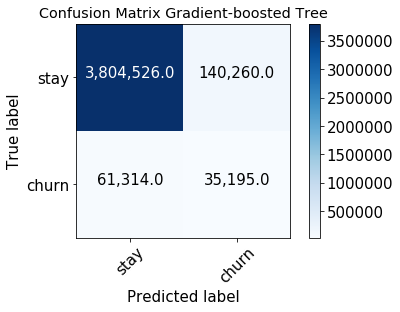

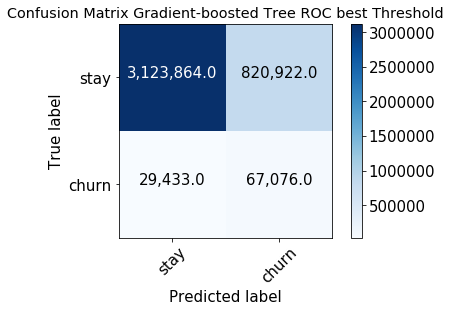

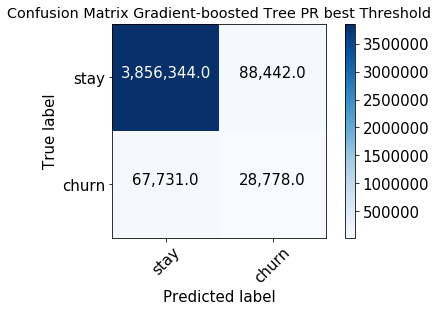

In [24]:
# Evaluation metrics calculation
precision_gbt_micro_final, recall_gbt_micro_final, fscore_gbt_micro_final = evaluate_model(
    confusion_matrix = cm_gbt_micro_final,  
    model_name = 'Gradient-boosted Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_gbt_micro_final, recall_roc_gbt_micro_final, fscore_roc_gbt_micro_final = evaluate_model(
    confusion_matrix = cm_roc_gbt_micro_final,
    model_name = 'Gradient-boosted Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_gbt_micro_final, recall_pr_gbt_micro_final, fscore_pr_gbt_micro_final = evaluate_model(
    confusion_matrix = cm_pr_gbt_micro_final,
    model_name = 'Gradient-boosted Tree PR best Threshold'
)

In [25]:
#Displaying Evaluation metrics as pandas dataframe
metrics_gbt_micro_final = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro-Final',
    precision = precision_gbt_micro_final, 
    recall = recall_gbt_micro_final, 
    fscore = fscore_gbt_micro_final, 
    roc_auc = roc_auc_gbt_micro_final, 
    pr_auc = pr_auc_gbt_micro_final
)
print("Metrics before threshold optimization: ")
display(metrics_gbt_micro_final)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_gbt_micro_final = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro-Final',
    precision = precision_roc_gbt_micro_final, 
    recall = recall_roc_gbt_micro_final, 
    fscore = fscore_roc_gbt_micro_final, 
    roc_auc = roc_auc_gbt_micro_final, 
    pr_auc = pr_auc_gbt_micro_final,
    roc_best_threshold = best_thresh_roc_curve_gbt_micro_final
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_gbt_micro_final = metrics_to_pandas(
    model = 'Gradient-boosted Tree Micro-Final',
    precision = precision_pr_gbt_micro_final, 
    recall = recall_pr_gbt_micro_final, 
    fscore = fscore_pr_gbt_micro_final, 
    roc_auc = roc_auc_gbt_micro_final, 
    pr_auc = pr_auc_gbt_micro_final,
    pr_best_threshold = best_thresh_pr_curve_gbt_micro_final
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_gbt_micro_final)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_gbt_micro_final)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro-Final,0.5,20.0593,36.4681,25.8821,0.809498,0.192311


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro-Final,0.0928788,7.55362,69.5023,13.6263,0.809498,0.192311


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Micro-Final,0.617549,24.5504,29.819,26.9294,0.809498,0.192311


In [26]:
session.stop()